## 1 Introduction

This dataset is obtained from a music player application at home, including **play**, **download**, and **search** data. The goal of our analysis is to **predict customer churn**. Generally, the customers who stop using a product or service for a given period of time are referred to as churners, and churn is one of the most important elements in the Key Performance Indicator (KPI). In this case, the date range of data is from 2017-03-30 to 2017-05-12. Therefore, if one user did not have action in the **last 2 weeks** (2017-04-29 to 2017-05-12), we define it as churn. After data cleaning, exploratory data analysis, feature engineering, and machine learning model building, we achieved an predictive power of **0.9**, as measured by the area under the ROC curve.

## 2 Preparations

### 2.1 Import libraries

In [1]:
# file and directory manipulation
import os
import requests
from bs4 import BeautifulSoup

# data manipulation and visualization
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

# date and time manipulation
import datetime
from dateutil import parser 

# spark functionality
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

# quantify quality of predictions
from sklearn.metrics import roc_curve, auc, roc_auc_score

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

### 2.2 Create folders

In [2]:
os.system('mkdir -p ../data/raw ../data/play ../data/down ../data/search')  

### 2.3 Download files

In [3]:
data_url = 'https://bittigermusicplayerdata.s3-us-west-2.amazonaws.com'
r = requests.get(data_url)
files = []
for file_name in BeautifulSoup(r.content).find_all('key'):
    one_file = str(file_name).lstrip('<key>').rstrip('</key>')
    files.append(one_file)

In [5]:
print(*files, sep = '\n')

1_1_search.log.tar.gz
1_2_search.log.tar.gz
1_3_search.log.tar.gz
1_4_search.log.tar.gz
20170301_play.log.gz
20170302_1_play.log.tar.gz
20170303_1_play.log.tar.gz
20170304_1_play.log.tar.gz
20170305_1_play.log.tar.gz
20170306_1_play.log.tar.gz
20170307_1_play.log.tar.gz
20170308_1_play.log.tar.gz
20170309_1_play.log.tar.gz
20170329_1_play.log.tar.gz
20170330_1_down.log.tar.gz
20170330_1_search.log.tar.gz
20170330_2_down.log.tar.gz
20170330_2_search.log.tar.gz
20170330_3.uids.tar.gz
20170330_3_down.log.tar.gz
20170330_3_play.log.tar.gz
20170330_3_search.log.tar.gz
20170331_1_down.log.tar.gz
20170331_1_play.log.tar.gz
20170331_1_search.log.tar.gz
20170331_2_down.log.tar.gz
20170331_2_play.log.tar.gz
20170331_2_search.log.tar.gz
20170331_3_down.log.tar.gz
20170331_3_play.log.tar.gz
20170331_3_search.log.tar.gz
20170401_1_down.log.tar.gz
20170401_1_play.log.tar.gz
20170401_1_search.log.tar.gz
20170401_2_down.log.tar.gz
20170401_2_play.log.tar.gz
20170401_2_search.log.tar.gz
20170401_3_down

In [4]:
file_list = [row for row in files if ('search.log.tar.gz' in row or
                                      'play.log.tar.gz' in row or
                                      'down.log.tar.gz' in row)]
# '20170422_3_play.log (1).tar.gz' is the same as '20170422_3_play.log.tar.gz'

# select files with date later than 2017-03-29
file_list = [row for row in file_list if row[:8]>='20170330']

In [5]:
def download_file(url, local_filename):
    r = requests.get(url, stream = True)  # ‘stream = True’ to delay downloading
    with open(local_filename, 'wb') as f:  # ‘wb’ to open in binary write mode
        for chunk in r.iter_content(chunk_size = 1024):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)
    return local_filename

In [7]:
# download the files
for file in file_list[]:
    download_file('https://bittigermusicplayerdata.s3-us-west-2.amazonaws.com/' + file,
                  '../data/raw/' + file)

### 2.4 Process files

In [11]:
# process play log (about 10 min)
os.chdir("../data/play")
os.popen('for f in ../raw/*_play.log.tar.gz;do \
              tar -xvzf $f -C .; \
              file=$(ls *.log); \
              echo "Processing $file"; \
              awk -v var="$file" \'{print $0, "\t", substr(var, 1, 8)}\' $file >> all_play_log; \
              rm $file; \
          done').read().splitlines()

['Processing 20170330_3_play.log',
 'Processing 20170331_1_play.log',
 'Processing 20170331_2_play.log',
 'Processing 20170331_3_play.log',
 'Processing 20170401_1_play.log',
 'Processing 20170401_2_play.log',
 'Processing 20170401_3_play.log',
 'Processing 20170402_1_play.log',
 'Processing 20170402_2_play.log',
 'Processing 20170402_3_play.log',
 'Processing 20170403_1_play.log',
 'Processing 20170403_2_play.log',
 'Processing 20170404_1_play.log',
 'Processing 20170404_2_play.log',
 'Processing 20170404_3_play.log',
 'Processing 20170405_1_play.log',
 'Processing 20170405_2_play.log',
 'Processing 20170405_3_play.log',
 'Processing 20170406_1_play.log',
 'Processing 20170406_2_play.log',
 'Processing 20170406_3_play.log',
 'Processing 20170407_1_play.log',
 'Processing 20170407_2_play.log',
 'Processing 20170407_3_play.log',
 'Processing 20170408_1_play.log',
 'Processing 20170408_2_play.log',
 'Processing 20170408_3_play.log',
 'Processing 20170409_1_play.log',
 'Processing 2017040

In [8]:
# process down log (pay attention to filename after decompressing)
os.chdir("../down")
os.popen('for f in ../raw/*_down.log.tar.gz;do \
              file_tmp=${f//..\/raw\//""}; \
              tar -xvzf $f -C .; \
              mv *.log ${file_tmp//.tar.gz/""}; \
              file=$(ls *.log); \
              echo "Processing $file"; \
              awk -v var="$file" \'{print $0, "\t", substr(var, 1, 8)}\' $file >> all_down_log; \
              rm $file; \
          done').read().splitlines()

['Processing 20170330_1_down.log',
 'Processing 20170330_2_down.log',
 'Processing 20170330_3_down.log',
 'Processing 20170331_1_down.log',
 'Processing 20170331_3_down.log',
 'Processing 20170401_1_down.log',
 'Processing 20170401_2_down.log',
 'Processing 20170401_3_down.log',
 'Processing 20170402_1_down.log',
 'Processing 20170402_2_down.log',
 'Processing 20170402_3_down.log',
 'Processing 20170403_1_down.log',
 'Processing 20170403_2_down.log',
 'Processing 20170403_3_down.log',
 'Processing 20170404_1_down.log',
 'Processing 20170404_2_down.log',
 'Processing 20170404_3_down.log',
 'Processing 20170405_1_down.log',
 'Processing 20170405_2_down.log',
 'Processing 20170405_3_down.log',
 'Processing 20170406_1_down.log',
 'Processing 20170406_2_down.log',
 'Processing 20170406_3_down.log',
 'Processing 20170407_1_down.log',
 'Processing 20170407_2_down.log',
 'Processing 20170407_3_down.log',
 'Processing 20170408_1_down.log',
 'Processing 20170408_2_down.log',
 'Processing 2017040

In [9]:
# process search log (pay attention to filename after decompressing & the third column is also date)
os.chdir("../search")
os.popen('for f in ../raw/*_search.log.tar.gz;do \
              file_tmp=${f//..\/raw\//""}; \
              tar -xvzf $f -C .; \
              mv *.log ${file_tmp//.tar.gz/""}; \
              file=$(ls *.log); \
              echo "Processing $file"; \
              awk -v var="$file" \'{print $0, "\t", substr(var, 1, 8)}\' $file >> all_search_log; \
              rm $file; \
          done').read().splitlines()

['Processing 20170330_1_search.log',
 'Processing 20170330_2_search.log',
 'Processing 20170330_3_search.log',
 'Processing 20170331_1_search.log',
 'Processing 20170331_2_search.log',
 'Processing 20170331_3_search.log',
 'Processing 20170401_1_search.log',
 'Processing 20170401_2_search.log',
 'Processing 20170401_3_search.log',
 'Processing 20170402_1_search.log',
 'Processing 20170402_2_search.log',
 'Processing 20170402_3_search.log',
 'Processing 20170403_1_search.log',
 'Processing 20170403_2_search.log',
 'Processing 20170403_3_search.log',
 'Processing 20170404_1_search.log',
 'Processing 20170404_2_search.log',
 'Processing 20170404_3_search.log',
 'Processing 20170405_1_search.log',
 'Processing 20170405_2_search.log',
 'Processing 20170405_3_search.log',
 'Processing 20170406_1_search.log',
 'Processing 20170406_2_search.log',
 'Processing 20170406_3_search.log',
 'Processing 20170407_1_search.log',
 'Processing 20170407_2_search.log',
 'Processing 20170407_3_search.log',
 

## 3 Clean & Downsample

### 3.1 Count users

In [26]:
# count unique user id
os.chdir("../../src")
os.system('export LC_CTYPE=C; \
           export LANG=C; \
           cut -f 1 ../data/play/all_play_log | sort | uniq -c | sed \'s/^ *//g\' > ../data/uid_count.csv')

0

In [2]:
df = pd.read_csv('../data/uid_count.csv', sep = '\s+', names = ['count', 'uid'])  

In [3]:
df.head()

,count,uid
0,2,NaN
1,1167848,0.0
2,2,100002491.0
3,56,100052111.0
4,9,100071797.0


In [28]:
df.describe()

,count,uid
count,5.947350e+05,5.947340e+05
mean,2.460525e+02,1.673628e+08
std,1.526662e+04,1.047142e+07
min,1.000000e+00,0.000000e+00
25%,9.000000e+00,1.680262e+08
50%,4.000000e+01,1.684782e+08
75%,1.740000e+02,1.687685e+08
max,7.501794e+06,1.692623e+08


### 3.2 Remove bots

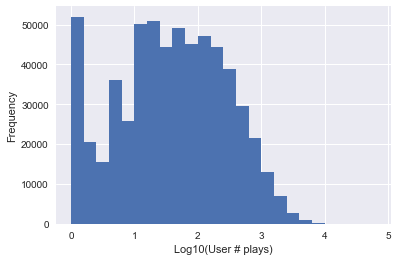

In [5]:
np.log10(df['count']).plot.hist(bins = np.arange(0, 5, 0.2))
plt.xlabel("Log10(User # plays)")
plt.show()

In [4]:
# define and remove bots (the number of listening songs of user is more than 10*60/5*45=5400)
# 10 - hours of listening to songs everyday; 5 - average song duration; 45 - total days in the dataset                     
print("total number of users:", len(df['uid']))

id_list_bot_removed = np.array(df['uid'][df['count'] < 5400].dropna())
print("total number of users after bot removed:", len(id_list_bot_removed))

total number of users: 594735
total number of users after bot removed: 594196


### 3.3 Downsample on uid level

In [5]:
np.random.seed = 0
down_sample_ratio = 0.1
id_subset = set(id_list_bot_removed[np.random.random(id_list_bot_removed.shape) < down_sample_ratio])
# np.random.random is alias for np.random.random_sample; return random floats in [0, 1)

total number of users after down sample: 59542


In [ ]:
print("total number of users after down sample:", len(id_subset))

In [6]:
# define date conversion function
def convert_date(s):
    s = str(s).strip()
    try:
        year = int(s[:4])
        month = int(s[4:6])
        day = int(s[6:8])
        return datetime.date(year, month, day)
    except:
        return None

In [23]:
# downsample play by uid
input_file = '../data/play/all_play_log'
output_file = '../data/play_ds.csv'
input_field_list = ['uid', 'device', 'song_id', 'song_type', 'song_name', 'singer',
                    'play_time', 'song_length', 'paid_flag', 'date']
output_field_list = ['uid', 'device', 'song_id', 'date', 'play_time', 'song_length']

i = 0
with open(input_file, 'r', encoding = 'latin-1') as fin, open(output_file, 'w') as fout:
    csvin = csv.DictReader(fin, delimiter = '\t', fieldnames = input_field_list, quoting = csv.QUOTE_NONE)
    csvout = csv.writer(fout, delimiter = ',')
    csvout.writerow(output_field_list)  # write header
    for row in csvin:
        i += 1
        if i%1000000 == 0:
            print("#row processed:", i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None:
                csvout.writerow([str(row[key]).strip() for key in output_field_list])

#row processed: 1000000
#row processed: 2000000
#row processed: 3000000
#row processed: 4000000
#row processed: 5000000
#row processed: 6000000
#row processed: 7000000
#row processed: 8000000
#row processed: 9000000
#row processed: 10000000
#row processed: 11000000
#row processed: 12000000
#row processed: 13000000
#row processed: 14000000
#row processed: 15000000
#row processed: 16000000
#row processed: 17000000
#row processed: 18000000
#row processed: 19000000
#row processed: 20000000
#row processed: 21000000
#row processed: 22000000
#row processed: 23000000
#row processed: 24000000
#row processed: 25000000
#row processed: 26000000
#row processed: 27000000
#row processed: 28000000
#row processed: 29000000
#row processed: 30000000
#row processed: 31000000
#row processed: 32000000
#row processed: 33000000
#row processed: 34000000
#row processed: 35000000
#row processed: 36000000
#row processed: 37000000
#row processed: 38000000
#row processed: 39000000
#row processed: 40000000
#row proc

In [9]:
# downsample download by uid
input_file = '../data/down/all_down_log'
output_file = '../data/down_ds.csv'
input_field_list = ['uid', 'device', 'song_id', 'song_name', 'singer', 'paid_flag', 'date']
output_field_list = ['uid', 'device', 'song_id', 'date']
i = 0
with open(input_file, 'r', encoding = 'latin-1') as fin, open(output_file, 'w') as fout:
    csvin = csv.DictReader(fin, delimiter = '\t', fieldnames = input_field_list, quoting = csv.QUOTE_NONE)
    csvout = csv.writer(fout, delimiter = ',')
    csvout.writerow(output_field_list)
    for row in csvin:
        i += 1
        if i %1000000 == 0:
            print('#row processed:', i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None:
                csvout.writerow([str(row[key]).strip() for key in output_field_list])

#row processed: 1000000
#row processed: 2000000
#row processed: 3000000
#row processed: 4000000
#row processed: 5000000
#row processed: 6000000
#row processed: 7000000


In [21]:
# downsample search by uid
input_file = '../data/search/all_search_log'
output_file = '../data/search_ds.csv'
input_field_list = ['uid', 'device', 'time_stamp', 'search_query', 'date']
output_field_list = ['uid', 'device', 'date']
i = 0
with open(input_file, 'r', encoding = 'latin-1') as fin, open(output_file, 'w') as fout:
    csvin = csv.DictReader(fin, delimiter = '\t', fieldnames = input_field_list, quoting = csv.QUOTE_NONE)
    csvout = csv.writer(fout, delimiter = ',')
    csvout.writerow(output_field_list)
    for row in csvin:
        i += 1
        if i%1000000 == 0:
            print('#row procedded:', i)
        try:
            int(row['uid'])
        except:
            continue
        if int(row['uid']) in id_subset:
            row['date'] = convert_date(row['date'])
            if row['date'] != None:
                csvout.writerow([str(row[key]).strip() for key in output_field_list])

#row procedded: 1000000
#row procedded: 2000000
#row procedded: 3000000
#row procedded: 4000000
#row procedded: 5000000
#row procedded: 6000000
#row procedded: 7000000
#row procedded: 8000000


### 3.4 Create event table

In [96]:
play_file = '../data/play_ds.csv'
down_file = '../data/down_ds.csv'
search_file = '../data/search_ds.csv'
output_file = '../data/event_ds.csv'
play_field_list = ['uid', 'device', 'song_id', 'date', 'play_time', 'song_length']
down_field_list = ['uid', 'device', 'song_id', 'date']
search_field_list = ['uid', 'device', 'date']
output_field_list = ['uid', 'event', 'song_id', 'date']
with open(play_file, 'r') as f_play, open(down_file, 'r') as f_down, \
open(search_file, 'r') as f_search, open(output_file, 'w') as f_out:
    csvplay = csv.DictReader(f_play, delimiter = ',')
    csvdown = csv.DictReader(f_down, delimiter = ',')
    csvsearch = csv.DictReader(f_search, delimiter = ',')
    csvout = csv.writer(f_out, delimiter = ',')
    csvout.writerow(output_field_list)
    print('Processing play ...')
    for row in csvplay:
        row['event'] = 'P'
        row['date']
        csvout.writerow([row[key] for key in output_field_list])
    print('Processing down ...')
    for row in csvdown:
        row['event'] = 'D'
        csvout.writerow([row[key] for key in output_field_list])
    print('Processing search ...')
    for row in csvsearch:
        row['event'] = 'S'
        csvout.writerow([row.get(key, '') for key in output_field_list])

Processing play ...
Processing down ...
Processing search ...


## 4 Exploratory data analysis

In [6]:
df = spark.read.csv('../data/event_ds.csv', header = True).cache()

In [7]:
df

DataFrame[uid: string, event: string, song_id: string, date: string]

In [8]:
df.show(5)

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168549788|    P|  295469|2017-03-30|
|168530895|    P|       0|2017-03-30|
|168549013|    P| 5256343|2017-03-30|
|168551085|    P|23491653|2017-03-30|
|168548840|    P|20066194|2017-03-30|
+---------+-----+--------+----------+
only showing top 5 rows



### 4.1 Convert datatype

In [9]:
# convert the date column from 'string' to 'date' type
df = df.withColumn('date', F.col('date').cast('date')) # 'cast()' is the alias of 'astype()'

In [10]:
df

DataFrame[uid: string, event: string, song_id: string, date: date]

In [11]:
df.show(5)

+---------+-----+--------+----------+
|      uid|event| song_id|      date|
+---------+-----+--------+----------+
|168549788|    P|  295469|2017-03-30|
|168530895|    P|       0|2017-03-30|
|168549013|    P| 5256343|2017-03-30|
|168551085|    P|23491653|2017-03-30|
|168548840|    P|20066194|2017-03-30|
+---------+-----+--------+----------+
only showing top 5 rows



### 4.2 Basic statistics

In [12]:
# count rows
print('Total number of rows:', df.count())

Total number of rows: 12337702


In [13]:
# count users
print('Total number of users:', df.select('uid').distinct().count())

Total number of users: 59541


In [14]:
# count event separately
df.groupBy('event').count().show()

+-----+--------+
|event|   count|
+-----+--------+
|    D|  599196|
|    S|  760960|
|    P|10977546|
+-----+--------+



In [51]:
# find the most active user in event separately (only consider the event count)

# download
D_top5 = df.filter(F.col('event') == 'D').groupBy('event', 'uid').count() \
                                         .orderBy(-F.col('count')).limit(5) \
                                         .withColumnRenamed('uid', 'max_uid')
D_top5.show()

# play
P_top5 = df.filter(F.col('event') == 'P').groupBy('event', 'uid').count() \
                                         .orderBy(-F.col('count')).limit(5) \
                                         .withColumnRenamed('uid', 'max_uid')
P_top5.show()

# search
S_top5 = df.filter(F.col('event') == 'S').groupBy('event', 'uid').count() \
                                         .orderBy(-F.col('count')).limit(5) \
                                         .withColumnRenamed('uid', 'max_uid')
S_top5.show()

# find overlap
D_top5.join(P_top5, on = 'max_uid', how = 'outer').join(S_top5, on = 'max_uid', how = 'outer') \
      .withColumnRenamed('max_uid', 'uid').show()
# the user with uid of 168580994 occurs in both download top5 and search download top5

+-----+---------+-----+
|event|  max_uid|count|
+-----+---------+-----+
|    D|168625124| 5987|
|    D|167979374| 5850|
|    D|168682355| 2850|
|    D|168580994| 2719|
|    D|167806728| 2433|
+-----+---------+-----+

+-----+---------+-----+
|event|  max_uid|count|
+-----+---------+-----+
|    P|168342661| 5393|
|    P|167827154| 5359|
|    P|167851784| 5288|
|    P|167968136| 5204|
|    P|167678765| 5164|
+-----+---------+-----+

+-----+---------+-----+
|event|  max_uid|count|
+-----+---------+-----+
|    S| 56472053| 1035|
|    S|168276029| 1019|
|    S|168455055|  945|
|    S|165789425|  838|
|    S|168580994|  770|
+-----+---------+-----+

+---------+-----+-----+-----+-----+-----+-----+
|      uid|event|count|event|count|event|count|
+---------+-----+-----+-----+-----+-----+-----+
|167968136| null| null|    P| 5204| null| null|
|168276029| null| null| null| null|    S| 1019|
|168455055| null| null| null| null|    S|  945|
|167827154| null| null|    P| 5359| null| null|
|168342661| n

### 4.3 Data visualization

In [69]:
# event level
event_date_count = df.groupBy('date').count().orderBy('date').toPandas()
event_date_count.head()

,date,count
0,2017-03-30,690722
1,2017-03-31,684774
2,2017-04-01,532301
3,2017-04-02,482583
4,2017-04-03,301279


In [75]:
def plot_bar(data, event):
    color_dict = dict({'Event': 'red', 'Play': 'deepskyblue',
                       'Download': 'orangered', 'Search': 'gold'})
    data['date'] = data['date'].apply(str)
    plt.figure(figsize = (12, 4))
    plt.bar(data['date'], data['count'], color = color_dict[event])
    plt.xticks(rotation = 'vertical')
    plt.xlabel('Date', fontsize = 15)
    plt.ylabel(event + ' count', fontsize = 15)
    plt.show()

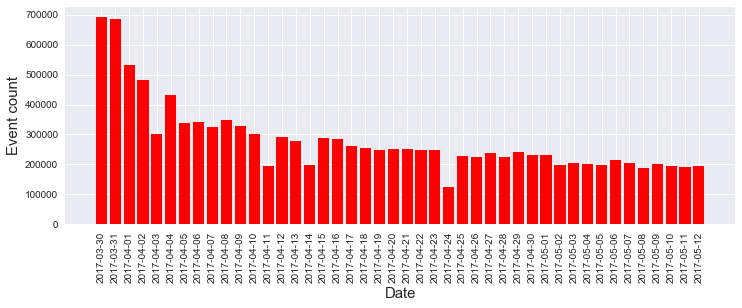

In [76]:
plot_bar(event_date_count, 'Event')

In [54]:
# play level
P_date_count = df.filter(F.col('event') == 'P').groupBy('event', 'date').count().orderBy('date').toPandas()
P_date_count.head()

,event,date,count
0,P,2017-03-30,443106
1,P,2017-03-31,600384
2,P,2017-04-01,474267
3,P,2017-04-02,429614
4,P,2017-04-03,252691


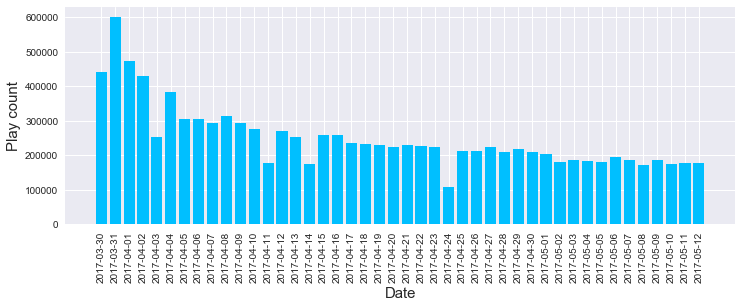

In [77]:
plot_bar(P_date_count, 'Play')

In [78]:
# download level
D_date_count = df.filter(F.col('event') == 'D').groupBy('event', 'date').count().orderBy('date').toPandas()
D_date_count.head()

,event,date,count
0,D,2017-03-30,134574
1,D,2017-03-31,35349
2,D,2017-04-01,27221
3,D,2017-04-02,24060
4,D,2017-04-03,21739


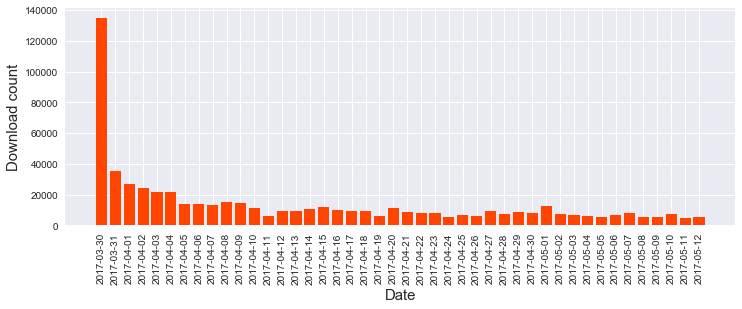

In [79]:
plot_bar(D_date_count, 'Download')

In [81]:
# search level
S_date_count = df.filter(F.col('event') == 'S').groupBy('event', 'date').count().orderBy('date').toPandas()
S_date_count.head()

,event,date,count
0,S,2017-03-30,113042
1,S,2017-03-31,49041
2,S,2017-04-01,30813
3,S,2017-04-02,28909
4,S,2017-04-03,26849


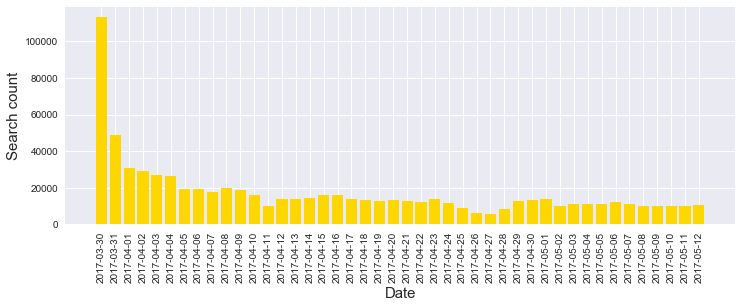

In [82]:
plot_bar(S_date_count, 'Search')

No matter from which perspectives, including total event, play, download, or search, frequency of user behavior is decreasing day by day. It may indicate that churn always exists.

## 4 Label definition

In [5]:
label_window_size = 14
label_window_end_date = parser.parse('2017-05-12').date()
label_window_start_date = label_window_end_date - datetime.timedelta(label_window_size - 1)
print('label window:', label_window_start_date, '~', label_window_end_date, 'days:', label_window_size)

label window: 2017-04-29 ~ 2017-05-12 days: 14


In [6]:
feature_window_size = 30
feature_window_end_date = label_window_start_date - datetime.timedelta(1)
feature_window_start_date = feature_window_end_date - datetime.timedelta(feature_window_size - 1)
print('feature window:', feature_window_start_date, '~', feature_window_end_date, 'days:', feature_window_size)

feature window: 2017-03-30 ~ 2017-04-28 days: 30


In [7]:
df_model_uid = df.filter((F.col('date') >= feature_window_start_date) &
                         (F.col('date') <= feature_window_end_date)).select('uid').distinct()
df_active_uid_in_label_window = df.filter((F.col('date') >= label_window_start_date) &
                                          (F.col('date') <= label_window_end_date)).select('uid').distinct() \
                                                                                   .withColumn('label', F.lit(0))

In [8]:
# prepare label data (churn label=1, active label=0)
df_label = df_model_uid.join(df_active_uid_in_label_window, on = ['uid'], how = 'left')
df_label = df_label.fillna(1)

In [9]:
# count churn and active users
df_label.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|36010|
|    0|22212|
+-----+-----+



## 5 Feature engineering

In [10]:
# event_data in feature window
df_feature_window = df.filter((F.col('date') >= feature_window_start_date) &
                              (F.col('date') <= feature_window_end_date))

### 5.1 Frequency

In [11]:
# define a function to generate frequency features for a list of time windows
# using when().otherwise() and list comprehension trick!
def frequency_feature_generation_time_windows(df, event, time_window_list, snapshot_date):
    """
    generate frequency features for one event type and a list of time windows
    """
    df_feature = df.filter(F.col('event') == event).groupBy('uid') \
                   .agg(*[F.sum(F.when((F.col('date') >= snapshot_date - datetime.timedelta(time_window - 1)) &
                                       (F.col('date') <= snapshot_date), 1).otherwise(0)) \
                                                                           .alias('freq_' + event + \
                                                                                  '_last_' + str(time_window)) \
                                for time_window in time_window_list])  # *[] opens list and make them comma separated
                   
    return df_feature

In [12]:
# generate one feature
event = 'S'
time_window_list = [1, 3, 7, 14, 30]
snapshot_date = feature_window_end_date
df_feature = frequency_feature_generation_time_windows(df_feature_window, event, time_window_list, snapshot_date)

In [22]:
df_feature.show(5)

+---------+-------------+-------------+-------------+--------------+--------------+
|      uid|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|
+---------+-------------+-------------+-------------+--------------+--------------+
|167899951|            0|            0|            1|             4|            10|
|168028443|            2|            5|           13|            13|            17|
|167650198|            0|            0|            0|             2|            17|
|167743862|            0|            0|            0|             0|             1|
|168044401|            0|            0|            0|             0|            10|
+---------+-------------+-------------+-------------+--------------+--------------+
only showing top 5 rows



In [13]:
# generate frequency features for all event_list, time_window_list
event_list = ['P', 'D', 'S']
time_window_list = [1, 3, 7, 14, 30]
df_feature_list = []
for event in event_list:
    df_feature_list.append(frequency_feature_generation_time_windows(df_feature_window, event,
                                                                     time_window_list, snapshot_date))

In [24]:
df_feature_list

[DataFrame[uid: string, freq_P_last_1: bigint, freq_P_last_3: bigint, freq_P_last_7: bigint, freq_P_last_14: bigint, freq_P_last_30: bigint],
 DataFrame[uid: string, freq_D_last_1: bigint, freq_D_last_3: bigint, freq_D_last_7: bigint, freq_D_last_14: bigint, freq_D_last_30: bigint],
 DataFrame[uid: string, freq_S_last_1: bigint, freq_S_last_3: bigint, freq_S_last_7: bigint, freq_S_last_14: bigint, freq_S_last_30: bigint]]

### 5.2 Recency

In [14]:
event_list = ['P', 'D', 'S']
df_recency = []
for event in event_list:
    df_recency.append(df_feature_window.filter(F.col('event') == event).groupBy('uid')\
                     .agg(F.max(F.col('date')).alias('last_' + event + '_date'))\
                     .select('uid', (F.datediff(F.lit('2017-04-28'), F.col('last_' + event + '_date')))\
                                    .alias('days_from_last_' + event)))

In [244]:
df_recency

[DataFrame[uid: string, days_from_last_P: int],
 DataFrame[uid: string, days_from_last_D: int],
 DataFrame[uid: string, days_from_last_S: int]]

### 5.3 Profile

In [15]:
df_play = spark.read.csv('../data/play_ds.csv', header = True)

In [30]:
df_play.show(5)

+---------+------+--------+----------+---------+-----------+
|      uid|device| song_id|      date|play_time|song_length|
+---------+------+--------+----------+---------+-----------+
|168549788|    ip|  295469|2017-03-30|       16|        242|
|168530895|    ar|       0|2017-03-30|      264|        265|
|168549013|    ip| 5256343|2017-03-30|      130|        265|
|168551085|    ar|23491653|2017-03-30|      312|        312|
|168548840|    ip|20066194|2017-03-30|       40|        223|
+---------+------+--------+----------+---------+-----------+
only showing top 5 rows



In [16]:
df_play_feature_window = df_play.filter((F.col('date') >= feature_window_start_date) &
                                        (F.col('date') <= feature_window_end_date))
df_profile_tmp = df_play_feature_window.select('uid', 'device').distinct()

In [32]:
df_profile_tmp.groupBy('device').count().show()

+------+-----+
|device|count|
+------+-----+
|    mc|    1|
|    ar|50827|
|    wp|    2|
|    ip| 7268|
+------+-----+



In [33]:
# check if one user has two devices
df_profile_tmp.count()

58098

In [34]:
df_profile_tmp.distinct().count() # one user only has one device

58098

In [17]:
df_profile_tmp = df_profile_tmp.withColumn('device_type', F.when(F.col('device') == 'ip', 1).otherwise(2))
df_profile_tmp.groupBy('device_type').count().show()

+-----------+-----+
|device_type|count|
+-----------+-----+
|          1| 7268|
|          2|50830|
+-----------+-----+



In [18]:
df_profile = df_label.select('uid').join(df_profile_tmp.select('uid', 'device_type'), on = 'uid', how = 'left')
df_profile.groupBy('device_type').count().show()

+-----------+-----+
|device_type|count|
+-----------+-----+
|       null|  146|
|          1| 7268|
|          2|50830|
+-----------+-----+



### 5.4 Total play time

In [19]:
# check if play time of users is negative
df_play_feature_window.filter(F.col('play_time') < 0).show()

+---------+------+-------+----------+------------+-----------------+
|      uid|device|song_id|      date|   play_time|      song_length|
+---------+------+-------+----------+------------+-----------------+
|168650646|    ip|7069830|2017-04-04| -2147483648|      -2147483648|
|168127306|    ip| 886288|2017-04-05|-7.911941426|272.8333333333333|
|168127306|    ip| 886288|2017-04-06|-7.911941426|272.8333333333333|
|168916105|    ip|6512395|2017-04-14| -2147483648|      -2147483648|
+---------+------+-------+----------+------------+-----------------+



In [20]:
df_play_feature_window_filter = df_play_feature_window.filter(F.col('play_time') >= 0)

In [21]:
time_window_list = [1, 3, 7, 14, 30]
df_total_play = df_play_feature_window_filter.groupBy('uid') \
            .agg(*[F.sum(F.when((F.col('date') >= feature_window_end_date-datetime.timedelta(time_window-1)) &
                                (F.col('date') <= feature_window_end_date), F.col('play_time')).otherwise(0))\
                                        .alias('total_play_time_last_' + str(time_window))
                                            for time_window in time_window_list])

In [42]:
df_total_play

DataFrame[uid: string, total_play_time_last_1: double, total_play_time_last_3: double, total_play_time_last_7: double, total_play_time_last_14: double, total_play_time_last_30: double]

### 5.5 Fancier frequency

In [37]:
# filter records with song length equal to 0
df_play_feature_window_final = df_play_feature_window_filter.filter(F.col('song_length') != 0)

In [40]:
time_window_list = [1, 3, 7, 14, 30]
df_fancier = df_play_feature_window_final.groupBy('uid') \
                   .agg(*[F.sum(F.when((F.col('date')>=feature_window_end_date-datetime.timedelta(time_window-1)) & \
                                       (F.col('date')<=feature_window_end_date) & \
                                       (F.col('play_time')/F.col('song_length')>=0.8) & \
                                       (F.col('play_time')/F.col('song_length')<=1), 1).otherwise(0)) \
                                          .alias('fancier_freq_last_' + str(time_window)) \
                        for time_window in time_window_list])

In [41]:
df_fancier

DataFrame[uid: string, fancier_freq_last_1: bigint, fancier_freq_last_3: bigint, fancier_freq_last_7: bigint, fancier_freq_last_14: bigint, fancier_freq_last_30: bigint]

### 5.6 Join features

In [43]:
def join_feature_data(df_master, df_feature_list):
    for df_feature in df_feature_list:
        df_master = df_master.join(df_feature, on = 'uid', how = 'left')
        df_master.persist()
    return df_master

In [44]:
# join all behavior features
df_model_final = join_feature_data(df_label, df_feature_list)

In [45]:
# join all recency features
df_model_final = join_feature_data(df_model_final, df_recency)

In [46]:
# join all profile features
df_model_final = join_feature_data(df_model_final, [df_profile])

In [47]:
# join all total play time features
df_model_final = join_feature_data(df_model_final, [df_total_play])

In [48]:
# join all fancier features
df_model_final = join_feature_data(df_model_final, [df_fancier])

In [49]:
df_model_final.fillna(0).toPandas().to_csv('../data/df_model_final.csv', index = False)

## 6 Model training

In [2]:
df = spark.read.csv('../data/df_model_final.csv', header = True, inferSchema = True).cache()
# 'inferSchema' is used to indicate whether automatic inference is used

In [3]:
df

DataFrame[uid: int, label: int, freq_P_last_1: int, freq_P_last_3: int, freq_P_last_7: int, freq_P_last_14: int, freq_P_last_30: int, freq_D_last_1: int, freq_D_last_3: int, freq_D_last_7: int, freq_D_last_14: int, freq_D_last_30: int, freq_S_last_1: int, freq_S_last_3: int, freq_S_last_7: int, freq_S_last_14: int, freq_S_last_30: int, days_from_last_P: int, days_from_last_D: int, days_from_last_S: int, device_type: int, total_play_time_last_1: double, total_play_time_last_3: double, total_play_time_last_7: double, total_play_time_last_14: double, total_play_time_last_30: double, fancier_freq_last_1: int, fancier_freq_last_3: int, fancier_freq_last_7: int, fancier_freq_last_14: int, fancier_freq_last_30: int]

In [4]:
df.show(1)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+-----------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-------------------+-------------------+-------------------+--------------------+--------------------+
|      uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|days_from_last_P|days_from_last_D|days_from_last_S|device_type|total_play_time_last_1|total_play_time_last_3|total_play_time_last_7|total_play_time_last_14|total_play_time_last_30|fancier_freq_last_1|fancier_freq_last_3|fancier_freq_last_7|fancier_fre

### 6.1 Prepare training and testing data

In [5]:
# one-hot encoding
encoder = OneHotEncoderEstimator(inputCols = ['device_type'], outputCols = ['device_type_cat'])
model = encoder.fit(df)
encoded = model.transform(df)
encoded.show(1)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+-----------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-------------------+-------------------+-------------------+--------------------+--------------------+---------------+
|      uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|days_from_last_P|days_from_last_D|days_from_last_S|device_type|total_play_time_last_1|total_play_time_last_3|total_play_time_last_7|total_play_time_last_14|total_play_time_last_30|fancier_freq_last_1|fancier_freq_last_3|fancier_freq_la

In [9]:
df = encoded.drop('device_type').withColumnRenamed('device_type_cat', 'device_type')
df_device_type = df.select('uid', 'device_type')

selected_features = df.columns
selected_features.remove('uid')
selected_features.remove('label')
selected_features.remove('device_type')
selected_features

['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 'days_from_last_P',
 'days_from_last_D',
 'days_from_last_S',
 'total_play_time_last_1',
 'total_play_time_last_3',
 'total_play_time_last_7',
 'total_play_time_last_14',
 'total_play_time_last_30',
 'fancier_freq_last_1',
 'fancier_freq_last_3',
 'fancier_freq_last_7',
 'fancier_freq_last_14',
 'fancier_freq_last_30']

In [10]:
# transform to a single vector
assembler = VectorAssembler(inputCols = selected_features, outputCol = 'features_no_device_type')
data = assembler.transform(df)

In [11]:
data.show(2)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------+-----------------------+
|      uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|days_from_last_P|days_from_last_D|days_from_last_S|total_play_time_last_1|total_play_time_last_3|total_play_time_last_7|total_play_time_last_14|total_play_time_last_30|fancier_freq_last_1|fancier_freq_last_3|fancier_freq_last

In [12]:
# standardization
scaler = StandardScaler(inputCol = 'features_no_device_type', outputCol = 'scaled_features_no_device_type')
scalerModel = scaler.fit(data)
scaleddata = scalerModel.transform(data).drop('features_no_device_type')
scaleddata.show(1)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+----------------+----------------+----------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-----------+------------------------------+
|      uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|days_from_last_P|days_from_last_D|days_from_last_S|total_play_time_last_1|total_play_time_last_3|total_play_time_last_7|total_play_time_last_14|total_play_time_last_30|fancier_freq_last_1|fancier_freq_last_3|fancier_freq

In [13]:
# transform to a single vector again
assembler = VectorAssembler(inputCols = ['scaled_features_no_device_type', 'device_type'], outputCol = 'features')
data = assembler.transform(scaleddata).drop('scaled_features_no_device_type')

In [14]:
# train test split
(train, test) = data.randomSplit([0.7, 0.3], seed = 0)

### 6.2 Logistic regression

In [15]:
ml = LogisticRegression(maxIter = 3, regParam = 0.01)  # regParam - regularization parameter
model = ml.fit(train)

In [16]:
# predict train data
predictions_train = model.transform(train)

# select example rows to display
predictions_train.select('probability', 'prediction', 'label', 'features').show(5)
res_train = predictions_train.select('probability', 'label').toPandas()

# predict test data
predictions_test = model.transform(test)

# select example rows to display
predictions_test.select('probability', 'prediction', 'label', 'features').show(5)
res_test = predictions_test.select('probability', 'label').toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.09092577572257...|       1.0|    1|(30,[4,14,15,17,2...|
|[0.90553718238353...|       0.0|    0|(30,[1,2,3,4,9,14...|
|[0.58924141372934...|       0.0|    0|(30,[1,2,3,4,14,1...|
|[0.98947447699840...|       0.0|    0|[1.50551143743704...|
|[0.44222658418936...|       1.0|    1|(30,[0,1,2,3,4,14...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.06984683715202...|       1.0|    1|(30,[4,15,22,27],...|
|[0.07400614689678...|       1.0|    1|(30,[4,14,15,17,2...|
|[0.96433284337961...|       0.0|    0|[1.20440914994963...|
|[0.48018982955096...|       1.0|    0|(30,[1,2,3,4,7,8,...|

In [17]:
# define plot function to evaluate performance
def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color = 'green', lw = lw, 
             label = 'ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color = 'darkorange', lw = lw, 
             label = 'ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = 'lower right')
    plt.show()

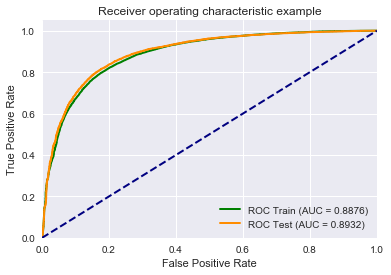

In [18]:
# evaluate performance
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

The performance of logistic model is good!

### 6.3 Random forest

In [19]:
ml = RandomForestClassifier(labelCol = 'label', featuresCol = 'features', numTrees = 50,
                            featureSubsetStrategy = 'auto', impurity = 'gini', maxDepth = 10,
                            minInstancesPerNode = 20, maxBins = 16)
# featureSubsetStrategy - the number of features to consider for splits at each tree node
# maxBins - max number of bins for discretizing continuous features
#           (must be >=2 and >= number of categories for any categorical feature.)
model = ml.fit(train)

In [20]:
# predict train data
predictions_train = model.transform(train)

# select example rows to display
predictions_train.select('probability', 'prediction', 'label','features').show(5)
res_train = predictions_train.select('probability', 'label').toPandas()

# predict test data
predictions_test = model.transform(test)

# select example rows to display
predictions_test.select('probability','prediction', 'label', 'features').show(5)
res_test = predictions_test.select('probability', 'label').toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.13043904789277...|       1.0|    1|(30,[4,14,15,17,2...|
|[0.93331313628961...|       0.0|    0|(30,[1,2,3,4,9,14...|
|[0.86680461192255...|       0.0|    0|(30,[1,2,3,4,14,1...|
|[0.98156697428871...|       0.0|    0|[1.50551143743704...|
|[0.57490795678765...|       0.0|    1|(30,[0,1,2,3,4,14...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.06134880584980...|       1.0|    1|(30,[4,15,22,27],...|
|[0.06010426469380...|       1.0|    1|(30,[4,14,15,17,2...|
|[0.99269829640765...|       0.0|    0|[1.20440914994963...|
|[0.75046190017654...|       0.0|    0|(30,[1,2,3,4,7,8,...|

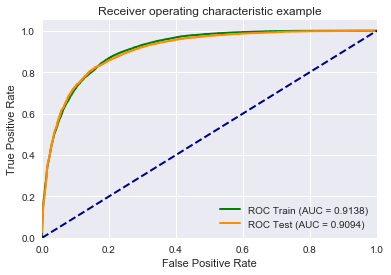

In [21]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

The performance of random forest is better than logistic regression!

## 7 Conclusion

We spent a lot of time **cleaning data** and **processing features** to understand connotation of data. For machine learning model, we chose logistic regression and random forest, because of the interpretability of the former and high accuracy of the latter. Exactly, AUC of these two models are both about 0.9. It is relatively meaningful for application.